In [1]:

# 0. 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
train = pd.read_csv('train.csv', index_col=0) # 코랩 사용 시 경로(/content/drive/My Drive/Colab Notebooks/) 추가
test = pd.read_csv('test.csv', index_col=0)
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)

# 2. Train 데이터의 타입을 Sample_submission에 대응하는 가변수 형태로 변환
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x : to_number(x, column_number))

# 3.모델에 적용할 데이터 셋 준비 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer

train_x = train.drop(columns=['type', 'type_num'], axis=1)
del train_x['fiberID']
train_y = train['type_num']
test_x = test
del test_x['fiberID']

train_x.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


In [2]:
# 간단한 이상치 제거

# 0.985,0.015
x = train_x.copy() 

down_quantiles = x.quantile(0.002) # 전처리 비율 조정
up_quantiles = x.quantile(0.998)

outliers_low = (x < down_quantiles)
outliers_high = (x > up_quantiles)

x[outliers_low] = np.nan
x.fillna(down_quantiles, inplace=True)

x[outliers_high] = np.nan
x.fillna(up_quantiles, inplace=True)

# 0.99, 0.01
x2 = train_x.copy() 

down_quantiles2 = x.quantile(0.02)
up_quantiles2 = x.quantile(0.98)

outliers_low2 = (x < down_quantiles2)
outliers_high2 = (x > up_quantiles2)

x2[outliers_low2] = np.nan
x2.fillna(down_quantiles2, inplace=True)

x2[outliers_high2] = np.nan
x2.fillna(up_quantiles2, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88ec256748>,
      dtype=object)

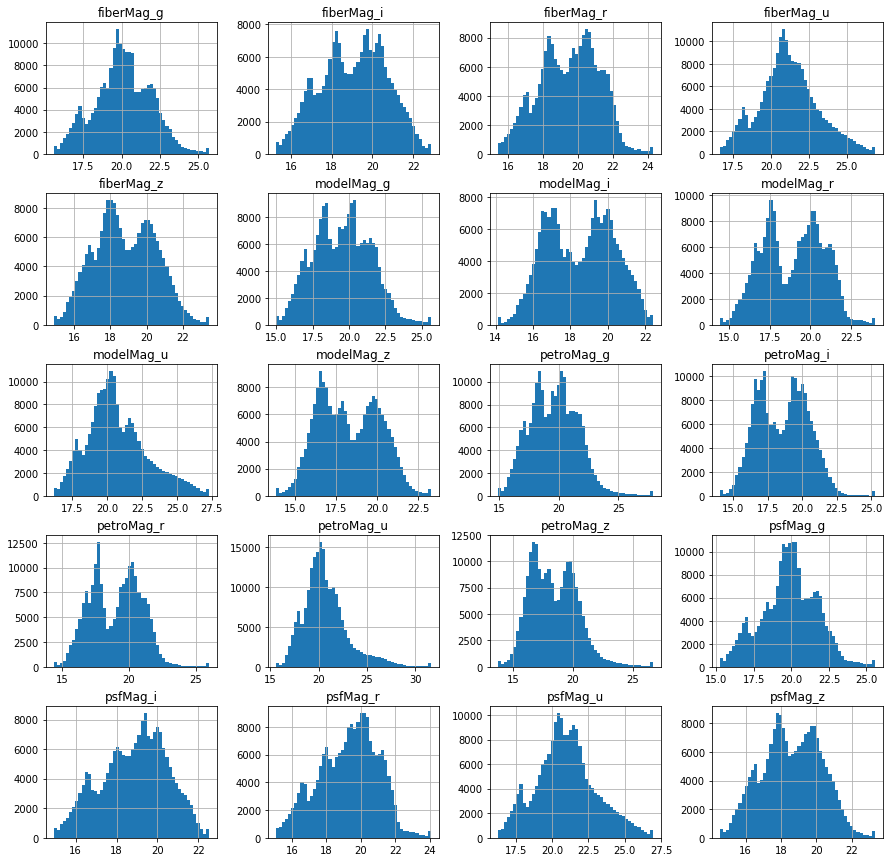

In [3]:
x.hist(bins=50, figsize=(15, 15))

In [4]:
x = x.values
train_y = train_y.values

x_train, x_val, y_train, y_val = train_test_split(x, train_y, train_size=0.9)

# 3-1 다중 분류 시 One-hot Encoding
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()
y_train = y_train.reshape(len(y_train), -1) 
y_val = y_val.reshape(len(y_val), -1)
y_train = onehot_encoder.fit_transform(y_train)
y_val = onehot_encoder.fit_transform(y_val)

print(x_train.shape)
print(y_train.shape)

(179991, 20)
(179991, 19)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'"

In [6]:
# StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

# 4. 모델 생성하기
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from keras import regularizers

model = Sequential()

model.add(Dense(128, input_shape=(20,))) #0.0007 # 정규화가 어느 정도 된 상태라서..?
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.07))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.07))
model.add(Dropout(0.45))
model.add(Dense(256))
model.add(BatchNormalization()) 
model.add(LeakyReLU(alpha=0.07))
model.add(Dropout(0.45))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.07))
model.add(Dropout(0.45))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.07))
model.add(Dropout(0.45))
model.add(Dense(19, activation='softmax'))


# 5. 모델 훈련시키기 
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=900, mode='min')
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])
hist = model.fit(x_train_scaled,y_train, epochs=5000, batch_size=256, validation_data = [x_val_scaled, y_val], callbacks=[early_stopping])

# # 6. 평가 검증하기
loss, acc = model.evaluate(x_val_scaled, y_val)
print('loss :', loss)
print('acc :', acc)

# 7. 예측
test_x_scaled = scaler.transform(test_x)
y_pred = model.predict(test_x_scaled)


# 8. 제출 파일 생성
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission(13).csv', index=True)


# early stopping patience 200 이상일 경우 overfitting
# Dropout 0.3 이하 overfitting 발생
# hidden layer 4개 이하 overfitting 발생
# node = 512일 경우 overfitting 발생

# 가장 기록 좋았을 때
# model = Sequential()

# model.add(Dense(128, input_shape=(20,)))
# model.add(LeakyReLU(alpha=0.07))
# model.add(BatchNormalization())
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(BatchNormalization())
# model.add(Dropout(0.45))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(BatchNormalization())
# model.add(Dropout(0.45))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(Dropout(0.45))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(Dropout(0.45))
# model.add(Dense(19, activation='softmax'))

Train on 179991 samples, validate on 20000 samples
Epoch 1/5000
179991/179991 [==============================] - 8s 44us/step - loss: 0.7808 - acc: 0.7570 - val_loss: 0.5130 - val_acc: 0.8285
Epoch 2/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.5824 - acc: 0.8105 - val_loss: 0.4954 - val_acc: 0.8245
Epoch 3/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.5489 - acc: 0.8187 - val_loss: 0.4919 - val_acc: 0.8316
Epoch 4/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.5294 - acc: 0.8238 - val_loss: 0.4540 - val_acc: 0.8450
Epoch 5/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.5167 - acc: 0.8276 - val_loss: 0.4589 - val_acc: 0.8400
Epoch 6/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.5129 - acc: 0.8286 - val_loss: 0.4500 - val_acc: 0.8474
Epoch 7/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.5031 - acc: 0.8317

179991/179991 [==============================] - 7s 37us/step - loss: 0.4394 - acc: 0.8502 - val_loss: 0.3919 - val_acc: 0.8613
Epoch 59/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4372 - acc: 0.8506 - val_loss: 0.3910 - val_acc: 0.8634
Epoch 60/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4372 - acc: 0.8509 - val_loss: 0.3914 - val_acc: 0.8632
Epoch 61/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4378 - acc: 0.8502 - val_loss: 0.4034 - val_acc: 0.8597
Epoch 62/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4368 - acc: 0.8513 - val_loss: 0.3931 - val_acc: 0.8612
Epoch 63/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4363 - acc: 0.8509 - val_loss: 0.4017 - val_acc: 0.8595
Epoch 64/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4361 - acc: 0.8510 - val_loss: 0.3882 - val_acc: 0.8630
Epoch 65/5000
179991

179991/179991 [==============================] - 7s 37us/step - loss: 0.4270 - acc: 0.8534 - val_loss: 0.3868 - val_acc: 0.8630
Epoch 116/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4262 - acc: 0.8532 - val_loss: 0.3921 - val_acc: 0.8589
Epoch 117/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4241 - acc: 0.8537 - val_loss: 0.3960 - val_acc: 0.8605
Epoch 118/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4236 - acc: 0.8547 - val_loss: 0.3857 - val_acc: 0.8642
Epoch 119/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4236 - acc: 0.8536 - val_loss: 0.3897 - val_acc: 0.8617
Epoch 120/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4232 - acc: 0.8541 - val_loss: 0.3913 - val_acc: 0.8610
Epoch 121/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4251 - acc: 0.8527 - val_loss: 0.3883 - val_acc: 0.8622
Epoch 122/5000

179991/179991 [==============================] - 6s 32us/step - loss: 0.4165 - acc: 0.8573 - val_loss: 0.3897 - val_acc: 0.8637
Epoch 173/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4183 - acc: 0.8559 - val_loss: 0.3857 - val_acc: 0.8640
Epoch 174/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4174 - acc: 0.8557 - val_loss: 0.3848 - val_acc: 0.8673
Epoch 175/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4191 - acc: 0.8551 - val_loss: 0.3887 - val_acc: 0.8622
Epoch 176/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4181 - acc: 0.8563 - val_loss: 0.3838 - val_acc: 0.8637
Epoch 177/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4162 - acc: 0.8565 - val_loss: 0.3971 - val_acc: 0.8612
Epoch 178/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4173 - acc: 0.8556 - val_loss: 0.3973 - val_acc: 0.8611
Epoch 179/5000

179991/179991 [==============================] - 6s 32us/step - loss: 0.4117 - acc: 0.8579 - val_loss: 0.3800 - val_acc: 0.8636
Epoch 230/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4131 - acc: 0.8565 - val_loss: 0.3844 - val_acc: 0.8640
Epoch 231/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4137 - acc: 0.8579 - val_loss: 0.3833 - val_acc: 0.8610
Epoch 232/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4129 - acc: 0.8574 - val_loss: 0.3817 - val_acc: 0.8616
Epoch 233/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4134 - acc: 0.8578 - val_loss: 0.4050 - val_acc: 0.8581
Epoch 234/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4132 - acc: 0.8574 - val_loss: 0.3820 - val_acc: 0.8641
Epoch 235/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4109 - acc: 0.8583 - val_loss: 0.3831 - val_acc: 0.8653
Epoch 236/5000

179991/179991 [==============================] - 6s 32us/step - loss: 0.4115 - acc: 0.8577 - val_loss: 0.3837 - val_acc: 0.8640
Epoch 287/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4089 - acc: 0.8590 - val_loss: 0.3842 - val_acc: 0.8619
Epoch 288/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4103 - acc: 0.8590 - val_loss: 0.3757 - val_acc: 0.8676
Epoch 289/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4099 - acc: 0.8579 - val_loss: 0.3917 - val_acc: 0.8630
Epoch 290/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4086 - acc: 0.8588 - val_loss: 0.3784 - val_acc: 0.8660
Epoch 291/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4083 - acc: 0.8593 - val_loss: 0.3845 - val_acc: 0.8634
Epoch 292/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4092 - acc: 0.8591 - val_loss: 0.3850 - val_acc: 0.8640
Epoch 293/5000

179991/179991 [==============================] - 6s 32us/step - loss: 0.4082 - acc: 0.8586 - val_loss: 0.3908 - val_acc: 0.8637
Epoch 344/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4080 - acc: 0.8587 - val_loss: 0.3828 - val_acc: 0.8662
Epoch 345/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4073 - acc: 0.8598 - val_loss: 0.3798 - val_acc: 0.8673
Epoch 346/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4076 - acc: 0.8585 - val_loss: 0.3771 - val_acc: 0.8667
Epoch 347/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4065 - acc: 0.8595 - val_loss: 0.3780 - val_acc: 0.8651
Epoch 348/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4067 - acc: 0.8594 - val_loss: 0.3927 - val_acc: 0.8600
Epoch 349/5000
179991/179991 [==============================] - 6s 32us/step - loss: 0.4066 - acc: 0.8591 - val_loss: 0.3806 - val_acc: 0.8648
Epoch 350/5000

179991/179991 [==============================] - 7s 37us/step - loss: 0.4056 - acc: 0.8594 - val_loss: 0.3763 - val_acc: 0.8684
Epoch 401/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4027 - acc: 0.8605 - val_loss: 0.3815 - val_acc: 0.8663
Epoch 402/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4054 - acc: 0.8597 - val_loss: 0.3786 - val_acc: 0.8672
Epoch 403/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4047 - acc: 0.8600 - val_loss: 0.3766 - val_acc: 0.8663
Epoch 404/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4062 - acc: 0.8596 - val_loss: 0.3773 - val_acc: 0.8676
Epoch 405/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4061 - acc: 0.8595 - val_loss: 0.3735 - val_acc: 0.8666
Epoch 406/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4041 - acc: 0.8606 - val_loss: 0.3811 - val_acc: 0.8643
Epoch 407/5000

179991/179991 [==============================] - 7s 37us/step - loss: 0.4037 - acc: 0.8614 - val_loss: 0.3768 - val_acc: 0.8683
Epoch 458/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4025 - acc: 0.8610 - val_loss: 0.3795 - val_acc: 0.8661
Epoch 459/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4033 - acc: 0.8609 - val_loss: 0.3897 - val_acc: 0.8660
Epoch 460/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.4061 - acc: 0.8592 - val_loss: 0.3795 - val_acc: 0.8698
Epoch 461/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4035 - acc: 0.8595 - val_loss: 0.3758 - val_acc: 0.8662
Epoch 462/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4047 - acc: 0.8592 - val_loss: 0.3873 - val_acc: 0.8626
Epoch 463/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4029 - acc: 0.8606 - val_loss: 0.3771 - val_acc: 0.8674
Epoch 464/5000

179991/179991 [==============================] - 7s 37us/step - loss: 0.4009 - acc: 0.8612 - val_loss: 0.3726 - val_acc: 0.8686
Epoch 515/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4000 - acc: 0.8613 - val_loss: 0.3810 - val_acc: 0.8655
Epoch 516/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4016 - acc: 0.8609 - val_loss: 0.3765 - val_acc: 0.8637
Epoch 517/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4006 - acc: 0.8616 - val_loss: 0.3834 - val_acc: 0.8656
Epoch 518/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.4007 - acc: 0.8609 - val_loss: 0.3762 - val_acc: 0.8684
Epoch 519/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4009 - acc: 0.8612 - val_loss: 0.3786 - val_acc: 0.8649
Epoch 520/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4024 - acc: 0.8612 - val_loss: 0.3775 - val_acc: 0.8661
Epoch 521/5000

179991/179991 [==============================] - 7s 37us/step - loss: 0.4008 - acc: 0.8615 - val_loss: 0.3811 - val_acc: 0.8643
Epoch 572/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4023 - acc: 0.8607 - val_loss: 0.3810 - val_acc: 0.8644
Epoch 573/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4006 - acc: 0.8613 - val_loss: 0.3831 - val_acc: 0.8637
Epoch 574/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3996 - acc: 0.8614 - val_loss: 0.3791 - val_acc: 0.8679
Epoch 575/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3996 - acc: 0.8615 - val_loss: 0.3879 - val_acc: 0.8656
Epoch 576/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.4016 - acc: 0.8604 - val_loss: 0.3849 - val_acc: 0.8659
Epoch 577/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4003 - acc: 0.8612 - val_loss: 0.3796 - val_acc: 0.8663
Epoch 578/5000

179991/179991 [==============================] - 7s 37us/step - loss: 0.3994 - acc: 0.8621 - val_loss: 0.3793 - val_acc: 0.8656
Epoch 629/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3990 - acc: 0.8617 - val_loss: 0.3794 - val_acc: 0.8663
Epoch 630/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4001 - acc: 0.8613 - val_loss: 0.3890 - val_acc: 0.8630
Epoch 631/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4003 - acc: 0.8609 - val_loss: 0.3811 - val_acc: 0.8649
Epoch 632/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.3981 - acc: 0.8624 - val_loss: 0.3780 - val_acc: 0.8676
Epoch 633/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.4011 - acc: 0.8614 - val_loss: 0.3775 - val_acc: 0.8667
Epoch 634/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.3981 - acc: 0.8614 - val_loss: 0.3803 - val_acc: 0.8662
Epoch 635/5000

179991/179991 [==============================] - 7s 38us/step - loss: 0.3980 - acc: 0.8624 - val_loss: 0.3873 - val_acc: 0.8650
Epoch 686/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3985 - acc: 0.8619 - val_loss: 0.3759 - val_acc: 0.8664
Epoch 687/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3990 - acc: 0.8614 - val_loss: 0.3803 - val_acc: 0.8674
Epoch 688/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3984 - acc: 0.8621 - val_loss: 0.3772 - val_acc: 0.8664
Epoch 689/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3967 - acc: 0.8628 - val_loss: 0.3825 - val_acc: 0.8633
Epoch 690/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.3977 - acc: 0.8617 - val_loss: 0.3727 - val_acc: 0.8674
Epoch 691/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3975 - acc: 0.8623 - val_loss: 0.3788 - val_acc: 0.8669
Epoch 692/5000

179991/179991 [==============================] - 7s 37us/step - loss: 0.3980 - acc: 0.8617 - val_loss: 0.3767 - val_acc: 0.8659
Epoch 743/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3979 - acc: 0.8623 - val_loss: 0.3776 - val_acc: 0.8666
Epoch 744/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3967 - acc: 0.8616 - val_loss: 0.3746 - val_acc: 0.8694
Epoch 745/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3968 - acc: 0.8633 - val_loss: 0.3837 - val_acc: 0.8648
Epoch 746/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3977 - acc: 0.8625 - val_loss: 0.3803 - val_acc: 0.8669
Epoch 747/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3973 - acc: 0.8623 - val_loss: 0.3777 - val_acc: 0.8687
Epoch 748/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3984 - acc: 0.8619 - val_loss: 0.3787 - val_acc: 0.8670
Epoch 749/5000

179991/179991 [==============================] - 7s 37us/step - loss: 0.3978 - acc: 0.8624 - val_loss: 0.3789 - val_acc: 0.8666
Epoch 800/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3977 - acc: 0.8620 - val_loss: 0.3824 - val_acc: 0.8663
Epoch 801/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3948 - acc: 0.8633 - val_loss: 0.3769 - val_acc: 0.8660
Epoch 802/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.3975 - acc: 0.8620 - val_loss: 0.3800 - val_acc: 0.8651
Epoch 803/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3956 - acc: 0.8627 - val_loss: 0.3771 - val_acc: 0.8670
Epoch 804/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3968 - acc: 0.8623 - val_loss: 0.3788 - val_acc: 0.8662
Epoch 805/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3976 - acc: 0.8619 - val_loss: 0.3785 - val_acc: 0.8687
Epoch 806/5000

179991/179991 [==============================] - 7s 37us/step - loss: 0.3961 - acc: 0.8627 - val_loss: 0.3810 - val_acc: 0.8659
Epoch 857/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3968 - acc: 0.8617 - val_loss: 0.3768 - val_acc: 0.8681
Epoch 858/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3965 - acc: 0.8625 - val_loss: 0.3849 - val_acc: 0.8614
Epoch 859/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.3955 - acc: 0.8626 - val_loss: 0.3840 - val_acc: 0.8655
Epoch 860/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.3938 - acc: 0.8630 - val_loss: 0.3820 - val_acc: 0.8675
Epoch 861/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3957 - acc: 0.8631 - val_loss: 0.3797 - val_acc: 0.8688
Epoch 862/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3966 - acc: 0.8629 - val_loss: 0.3787 - val_acc: 0.8666
Epoch 863/5000

179991/179991 [==============================] - 7s 37us/step - loss: 0.3942 - acc: 0.8624 - val_loss: 0.3805 - val_acc: 0.8671
Epoch 914/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3949 - acc: 0.8629 - val_loss: 0.3773 - val_acc: 0.8663
Epoch 915/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.3924 - acc: 0.8639 - val_loss: 0.3805 - val_acc: 0.8670
Epoch 916/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3970 - acc: 0.8619 - val_loss: 0.3801 - val_acc: 0.8672
Epoch 917/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.3939 - acc: 0.8629 - val_loss: 0.3777 - val_acc: 0.8681
Epoch 918/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3946 - acc: 0.8631 - val_loss: 0.3788 - val_acc: 0.8666
Epoch 919/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3940 - acc: 0.8630 - val_loss: 0.3831 - val_acc: 0.8651
Epoch 920/5000

179991/179991 [==============================] - 7s 37us/step - loss: 0.3946 - acc: 0.8637 - val_loss: 0.3835 - val_acc: 0.8641
Epoch 971/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3936 - acc: 0.8636 - val_loss: 0.3827 - val_acc: 0.8679
Epoch 972/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3951 - acc: 0.8629 - val_loss: 0.3766 - val_acc: 0.8689
Epoch 973/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3933 - acc: 0.8625 - val_loss: 0.3746 - val_acc: 0.8686
Epoch 974/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.3933 - acc: 0.8634 - val_loss: 0.3801 - val_acc: 0.8684
Epoch 975/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3938 - acc: 0.8637 - val_loss: 0.3822 - val_acc: 0.8667
Epoch 976/5000
179991/179991 [==============================] - 7s 38us/step - loss: 0.3942 - acc: 0.8630 - val_loss: 0.3792 - val_acc: 0.8682
Epoch 977/5000

179991/179991 [==============================] - 7s 38us/step - loss: 0.3924 - acc: 0.8642 - val_loss: 0.3815 - val_acc: 0.8644
Epoch 1028/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3949 - acc: 0.8634 - val_loss: 0.3770 - val_acc: 0.8683
Epoch 1029/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3938 - acc: 0.8635 - val_loss: 0.3821 - val_acc: 0.8655
Epoch 1030/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3941 - acc: 0.8626 - val_loss: 0.3821 - val_acc: 0.8673
Epoch 1031/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3923 - acc: 0.8633 - val_loss: 0.3753 - val_acc: 0.8688
Epoch 1032/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3944 - acc: 0.8629 - val_loss: 0.3782 - val_acc: 0.8666
Epoch 1033/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3937 - acc: 0.8632 - val_loss: 0.3832 - val_acc: 0.8666
Epoch 10

179991/179991 [==============================] - 7s 37us/step - loss: 0.3936 - acc: 0.8632 - val_loss: 0.3796 - val_acc: 0.8679
Epoch 1085/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3922 - acc: 0.8634 - val_loss: 0.3733 - val_acc: 0.8700
Epoch 1086/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3918 - acc: 0.8640 - val_loss: 0.3791 - val_acc: 0.8666
Epoch 1087/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3936 - acc: 0.8631 - val_loss: 0.3773 - val_acc: 0.8689
Epoch 1088/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3946 - acc: 0.8632 - val_loss: 0.3748 - val_acc: 0.8687
Epoch 1089/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3930 - acc: 0.8637 - val_loss: 0.3800 - val_acc: 0.8668
Epoch 1090/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3928 - acc: 0.8635 - val_loss: 0.3821 - val_acc: 0.8669
Epoch 10

179991/179991 [==============================] - 7s 37us/step - loss: 0.3933 - acc: 0.8638 - val_loss: 0.3718 - val_acc: 0.8720
Epoch 1142/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3935 - acc: 0.8643 - val_loss: 0.3790 - val_acc: 0.8681
Epoch 1143/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3921 - acc: 0.8639 - val_loss: 0.3865 - val_acc: 0.8659
Epoch 1144/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3921 - acc: 0.8635 - val_loss: 0.3829 - val_acc: 0.8666
Epoch 1145/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3946 - acc: 0.8626 - val_loss: 0.3750 - val_acc: 0.8699
Epoch 1146/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3905 - acc: 0.8641 - val_loss: 0.3789 - val_acc: 0.8669
Epoch 1147/5000
179991/179991 [==============================] - 7s 37us/step - loss: 0.3926 - acc: 0.8634 - val_loss: 0.3857 - val_acc: 0.8640
Epoch 11

179991/179991 [==============================] - 5s 30us/step - loss: 0.3941 - acc: 0.8637 - val_loss: 0.3839 - val_acc: 0.8648
Epoch 1199/5000
179991/179991 [==============================] - 5s 30us/step - loss: 0.3939 - acc: 0.8627 - val_loss: 0.3849 - val_acc: 0.8659
Epoch 1200/5000
179991/179991 [==============================] - 5s 30us/step - loss: 0.3923 - acc: 0.8640 - val_loss: 0.3826 - val_acc: 0.8650
Epoch 1201/5000
179991/179991 [==============================] - 5s 30us/step - loss: 0.3915 - acc: 0.8640 - val_loss: 0.3809 - val_acc: 0.8655
Epoch 1202/5000
179991/179991 [==============================] - 5s 30us/step - loss: 0.3912 - acc: 0.8639 - val_loss: 0.3761 - val_acc: 0.8703
Epoch 1203/5000
179991/179991 [==============================] - 5s 31us/step - loss: 0.3903 - acc: 0.8644 - val_loss: 0.3829 - val_acc: 0.8666
Epoch 1204/5000
179991/179991 [==============================] - 5s 30us/step - loss: 0.3924 - acc: 0.8632 - val_loss: 0.3784 - val_acc: 0.8681
Epoch 12

179991/179991 [==============================] - 4s 21us/step - loss: 0.3910 - acc: 0.8649 - val_loss: 0.3788 - val_acc: 0.8674
Epoch 1256/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3910 - acc: 0.8637 - val_loss: 0.3820 - val_acc: 0.8679
Epoch 1257/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3910 - acc: 0.8639 - val_loss: 0.3811 - val_acc: 0.8679
Epoch 1258/5000
179991/179991 [==============================] - 4s 22us/step - loss: 0.3916 - acc: 0.8646 - val_loss: 0.3777 - val_acc: 0.8705
Epoch 1259/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3908 - acc: 0.8644 - val_loss: 0.3813 - val_acc: 0.8687
Epoch 1260/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3917 - acc: 0.8637 - val_loss: 0.3840 - val_acc: 0.8684
Epoch 1261/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3911 - acc: 0.8645 - val_loss: 0.3779 - val_acc: 0.8700
Epoch 12

179991/179991 [==============================] - 4s 21us/step - loss: 0.3906 - acc: 0.8644 - val_loss: 0.3785 - val_acc: 0.8670
Epoch 1313/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3924 - acc: 0.8636 - val_loss: 0.3751 - val_acc: 0.8694
Epoch 1314/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3896 - acc: 0.8639 - val_loss: 0.3838 - val_acc: 0.8662
Epoch 1315/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3911 - acc: 0.8640 - val_loss: 0.3766 - val_acc: 0.8684
Epoch 1316/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3921 - acc: 0.8637 - val_loss: 0.3834 - val_acc: 0.8651
Epoch 1317/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3901 - acc: 0.8648 - val_loss: 0.3753 - val_acc: 0.8666
Epoch 1318/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3908 - acc: 0.8638 - val_loss: 0.3764 - val_acc: 0.8697
Epoch 13

179991/179991 [==============================] - 4s 21us/step - loss: 0.3902 - acc: 0.8642 - val_loss: 0.3800 - val_acc: 0.8667
Epoch 1370/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3905 - acc: 0.8648 - val_loss: 0.3758 - val_acc: 0.8716
Epoch 1371/5000
179991/179991 [==============================] - 4s 22us/step - loss: 0.3899 - acc: 0.8645 - val_loss: 0.3820 - val_acc: 0.8680
Epoch 1372/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3922 - acc: 0.8636 - val_loss: 0.3768 - val_acc: 0.8691
Epoch 1373/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3905 - acc: 0.8652 - val_loss: 0.3765 - val_acc: 0.8687
Epoch 1374/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3892 - acc: 0.8643 - val_loss: 0.3789 - val_acc: 0.8691
Epoch 1375/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3902 - acc: 0.8637 - val_loss: 0.3805 - val_acc: 0.8676
Epoch 13

179991/179991 [==============================] - 4s 21us/step - loss: 0.3901 - acc: 0.8638 - val_loss: 0.3811 - val_acc: 0.8673
Epoch 1427/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3883 - acc: 0.8651 - val_loss: 0.3791 - val_acc: 0.8669
Epoch 1428/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3887 - acc: 0.8655 - val_loss: 0.3816 - val_acc: 0.8673
Epoch 1429/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3888 - acc: 0.8650 - val_loss: 0.3773 - val_acc: 0.8666
Epoch 1430/5000
179991/179991 [==============================] - 4s 21us/step - loss: 0.3897 - acc: 0.8645 - val_loss: 0.3817 - val_acc: 0.8662
Epoch 1431/5000
179991/179991 [==============================] - 4s 22us/step - loss: 0.3890 - acc: 0.8644 - val_loss: 0.3835 - val_acc: 0.8651
Epoch 1432/5000
179991/179991 [==============================] - 4s 22us/step - loss: 0.3899 - acc: 0.8648 - val_loss: 0.3750 - val_acc: 0.8680
Epoch 14

179991/179991 [==============================] - 4s 22us/step - loss: 0.3899 - acc: 0.8650 - val_loss: 0.3774 - val_acc: 0.8684
Epoch 1484/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3889 - acc: 0.8654 - val_loss: 0.3829 - val_acc: 0.8658
Epoch 1485/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3898 - acc: 0.8641 - val_loss: 0.3802 - val_acc: 0.8661
Epoch 1486/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3881 - acc: 0.8651 - val_loss: 0.3841 - val_acc: 0.8668
Epoch 1487/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3890 - acc: 0.8644 - val_loss: 0.3793 - val_acc: 0.8676
Epoch 1488/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3905 - acc: 0.8639 - val_loss: 0.3804 - val_acc: 0.8666
Epoch 1489/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3912 - acc: 0.8645 - val_loss: 0.3794 - val_acc: 0.8684
Epoch 14

179991/179991 [==============================] - 4s 23us/step - loss: 0.3887 - acc: 0.8652 - val_loss: 0.3770 - val_acc: 0.8690
Epoch 1541/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3889 - acc: 0.8652 - val_loss: 0.3799 - val_acc: 0.8686
Epoch 1542/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3887 - acc: 0.8650 - val_loss: 0.3854 - val_acc: 0.8650
Epoch 1543/5000
179991/179991 [==============================] - 4s 24us/step - loss: 0.3888 - acc: 0.8656 - val_loss: 0.3793 - val_acc: 0.8679
Epoch 1544/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3905 - acc: 0.8643 - val_loss: 0.3776 - val_acc: 0.8694
Epoch 1545/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3904 - acc: 0.8639 - val_loss: 0.3821 - val_acc: 0.8682
Epoch 1546/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3882 - acc: 0.8653 - val_loss: 0.3820 - val_acc: 0.8669
Epoch 15

179991/179991 [==============================] - 4s 24us/step - loss: 0.3875 - acc: 0.8649 - val_loss: 0.3752 - val_acc: 0.8683
Epoch 1598/5000
179991/179991 [==============================] - 4s 24us/step - loss: 0.3874 - acc: 0.8654 - val_loss: 0.3770 - val_acc: 0.8666
Epoch 1599/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3894 - acc: 0.8643 - val_loss: 0.3793 - val_acc: 0.8657
Epoch 1600/5000
179991/179991 [==============================] - 4s 24us/step - loss: 0.3878 - acc: 0.8643 - val_loss: 0.3844 - val_acc: 0.8657
Epoch 1601/5000
179991/179991 [==============================] - 4s 24us/step - loss: 0.3873 - acc: 0.8648 - val_loss: 0.3760 - val_acc: 0.8681
Epoch 1602/5000
179991/179991 [==============================] - 4s 23us/step - loss: 0.3870 - acc: 0.8656 - val_loss: 0.3807 - val_acc: 0.8681
Epoch 1603/5000
179991/179991 [==============================] - 4s 24us/step - loss: 0.3886 - acc: 0.8647 - val_loss: 0.3755 - val_acc: 0.8680
Epoch 16

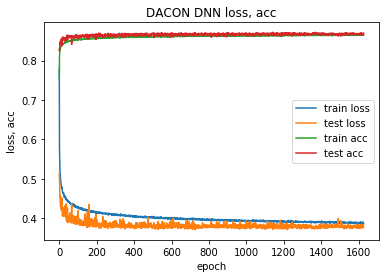

In [7]:
# matplotlib으로 보기
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('DACON DNN loss, acc')
plt.xlabel('epoch')
plt.ylabel('loss, acc')
plt.legend(['train loss', 'test loss', 'train acc', 'test acc'])
plt.show()

# First
# loss : 0.3751423681736819
# acc : 0.8720957365285246

# Second
# loss : 0.37057404349997003
# acc : 0.8689456582069397

# Third
# loss : 0.36412223417814554
# acc : 0.8720468282699585

# Fourth
# loss: 0.3597

# Fifth
# loss: 

# 최소 0.35~0.33까지 떨어뜨려야 함
# 참고 epoch 30% = earlystopping